# Partial Dependence  Documentation

This notebook is designed to demonstrate how to use `mintpy` to compute 1D or 2D partial dependence and plot the results. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import mintpy
import plotting_config 

## Loading the training data and pre-fit models 

In [3]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()

## Loading feature rankings for a list of features to explore with PD

In [4]:
myInterpreter = mintpy.InterpretToolkit(model=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

# Load the permutation important results from the saved pickle file
results = myInterpreter.load_results(fnames='multipass_importance.pkl', 
                                     option='permutation_importance',
                                    model_names=['Random Forest', 'Gradient Boosting'])

print(results)
important_vars = myInterpreter.get_important_vars(results, multipass=True, nvars=7)
print(important_vars)

Loading results from multipass_importance.pkl...
{'Logistic Regression': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7fc174a8bf28>, 'Gradient Boosting': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7fc190a8ccf8>, 'Random Forest': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7fc187549048>}
['sfcT_hrs_bl_frez', 'date_marker', 'tmp2m_hrs_bl_frez', 'd_rad_d', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'dwpt2m', 'swave_flux', 'uplwav_flux', 'sfc_temp', 'sat_irbt', 'temp2m']


# Partial Dependence Plots

Once we known what features are important, we explore their functional relationship with the target variable. MintPy has a built-in function to take the important features from multiple model turn it into a single list with any duplicate features removed. 

Using 9 processors...


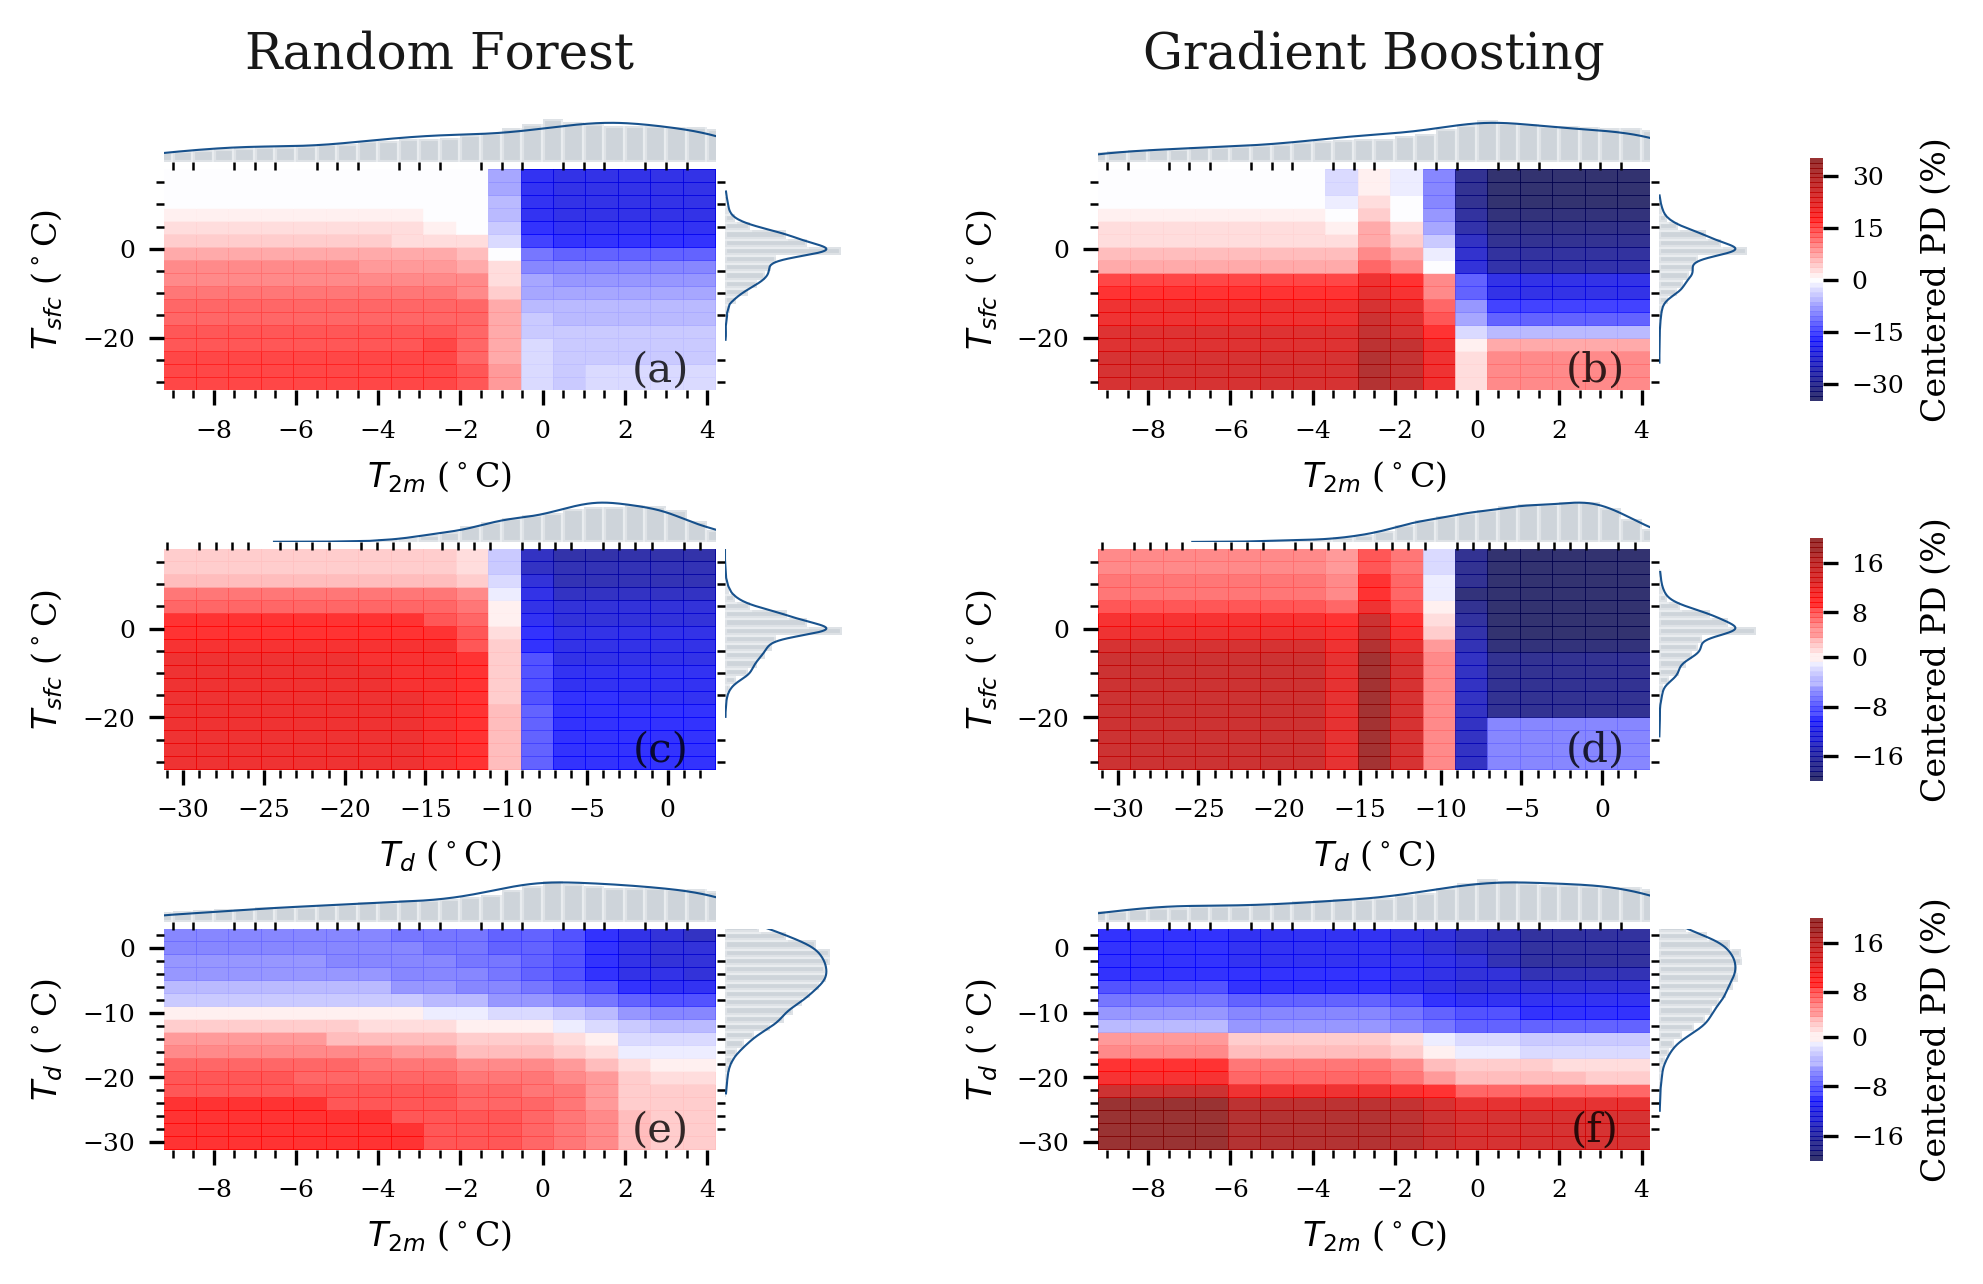

In [5]:
features=[('temp2m', 'sfc_temp'), ('dwpt2m', 'sfc_temp'), ('temp2m', 'dwpt2m')]
results = myInterpreter.calc_pd(features=features, 
                                 nbootstrap=1, 
                                 subsample=0.01,
                                 njobs=len(features)*len(model_names),
                                 nbins=20
                                )

fig, axes = myInterpreter.plot_pd(feature_units=plotting_config.feature_units,
                                   readable_feature_names=plotting_config.readable_feature_names
                                  )

In [6]:
h_value = myInterpreter.calc_feature_interactions(model_name='Random Forest', 
                                                  features = ('dllwave_flux', 'dwpt2m'), 
                                                  nbins=15
                                                 )

NameError: name 'PartialDependence' is not defined

In [ ]:
print(h_value)